In [26]:
import requests
import re
import matplotlib.pyplot as plt
import collections
from wordcloud import WordCloud

class InstagramTagCloud:    
    # fieldsパラメーターを指定. childrenは除外
    fields = "timestamp,media_type,like_count,comments_count,caption,media_url,permalink,id"
    
    #  コンストラクタ引数：インスタグラムのビジネスアカウントID、APIのトークン. この2つの情報を持ったインスタンスを生成する.それに対してメソッドを作用させる
    def __init__(self, business_account_id, access_token):
        # インスタンス変数（メンバ変数）の設定
        self.business_account_id= business_account_id
        self.access_token = access_token
        
    
    # ハッシュタグIDを取得
    def get_hashtag_id(self, hashtag_query):
        # ハッシュタグID取得用URL
        ig_hashtagID_search_api = f"https://graph.facebook.com/ig_hashtag_search?user_id={self.business_account_id}&q={hashtag_query}&access_token={self.access_token}"
        # レスポンスをPythonが扱うことのできる対象（JSON）に変換し、IDを取得
        hash_id = requests.get(ig_hashtagID_search_api).json()['data'][0]['id']
        return hash_id
    
    # APIを叩いて見た目JSON形式のデータを取得
    def request_media(self, hashtag_query, search_type, num=100):
        # ハッシュタグID取得
        hash_id = self.get_hashtag_id(hashtag_query)
        
        # ハッシュタグ検索用URL
        if search_type == 'top':
            search_type = 'top_media'
        elif search_type == 'recent':
            search_type = 'recent_media'
        else:
            print("Error : 第2引数には、'top'か'recent'を入力してください")
        
        # 取得数に応じて条件分岐
        if num <= 50:
            hashtag_search_api = f"https://graph.facebook.com/{hash_id}/{search_type}?user_id={self.business_account_id}&fields={self.fields}&access_token={self.access_token}&limit={str(num)}"
            # レスポンスをPythonが扱うことのできる対象（JSON）に変換
            res_original = requests.get(hashtag_search_api).json()
            res_data = res_original['data']
        else:
            hashtag_search_api = f"https://graph.facebook.com/{hash_id}/{search_type}?user_id={self.business_account_id}&fields={self.fields}&access_token={self.access_token}&limit={str(num)}"
            # レスポンスをPythonが扱うことのできる対象（JSON）に変換
            res_original = requests.get(hashtag_search_api).json()
            res_data = res_original['data']
            # APIの仕様上、一度のリクエストで取得できるのは最大50件までなので、それ以上取得したい場合は2回リクエストを送る
            next_50_url = res_original['paging']['next']
            
            for data in requests.get(next_50_url).json()['data']:
                res_data.append(data)
        
        result = {}
    
        for post in res_data:   
            id = post['id']
            caption = post['caption']
            result[id] = self.extractHashtag(caption)


        return result

    # キャプションから抽出したハッシュタグのリストを返す関数
    def extractHashtag(self, caption):
        pattern = r'#([^#\s$]+)'
        result = re.findall(pattern, caption)
        
        return result

In [27]:
# あらかじめIDとtokenは取得しておく
business_account_id ='***********'
access_token = '***********'

# 検索ワードと検索タイプを指定
hastag_object = InstagramTagCloud(business_account_id, access_token)
hashtag_dict = hastag_object.request_media('神戸', 'top')
len(hashtag_dict)

100

In [28]:
# ハッシュタグの集計
hashtag_list = []
for lst in hashtag_dict.values():
    # リスト同士の結合
    hashtag_list.extend(lst)
    
# ハッシュタグ集計プログラム
# collections.Counterを用いてタグの出現回数をカウントし、上位30タグを抽出
tag_count = dict(collections.Counter(hashtag_list).most_common(30))

## Word Cloud の作成

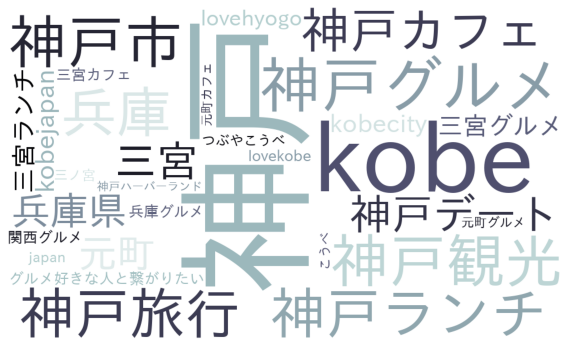

In [30]:
FONT_PATH = r'フォントの保存場所（フルパス）'
cloud = WordCloud(font_path=FONT_PATH, background_color='white', width=1000, height=600, colormap='bone').fit_words(tag_count)
plt.figure(figsize=(10, 8))
plt.imshow(cloud)
plt.axis('off')
plt.show()